In [1]:
import os
import numpy as np
import pandas as pd

from gurobipy import *

import matplotlib.pyplot as plt

In [2]:
%matplotlib notebook

In [3]:
m = Model('system')

arcs = [
    ("GRID", "BAT"),
    ("BAT", "ELEC"),
    ("GRID", "HP"),
    ("HP", "HEAT"),
    ("GAS", "CHP"),
    ("CHP", "ELEC"),
    ("CHP", "HEAT")
]

Academic license - for non-commercial use only


In [4]:
load_elec = pd.read_csv("load_elec.csv", index_col=0, squeeze=True)
load_heat = pd.read_csv("load_heat.csv", index_col=0, squeeze=True)

In [5]:
nb_of_periods = len(load_heat)

flows = m.addVars(arcs, nb_of_periods, name="flows")

In [6]:
cop = 3.0

cstr_hp = m.addConstrs(
    (cop * flows["GRID", "HP", i] - flows["HP", "HEAT", i] == 0 
     for i in range(nb_of_periods)))

In [7]:
eff_heat = 0.4
eff_elec = 0.3

cstr_chp_heat = m.addConstrs(
    (eff_heat * flows["GAS", "CHP", i] - flows["CHP", "HEAT", i] == 0 
     for i in range(nb_of_periods)))

cstr_chp_elec = m.addConstrs(
    (eff_elec * flows["GAS", "CHP", i] - flows["CHP", "ELEC", i] == 0 
     for i in range(nb_of_periods)))

In [8]:
cstr_load_elec = m.addConstrs(
    (flows.sum('*', "ELEC", i) == load_elec.iloc[i]
     for i in range(nb_of_periods)))

cstr_load_heat = m.addConstrs(
    (flows.sum('*', "HEAT", i) == load_heat.iloc[i]
     for i in range(nb_of_periods)))

In [9]:
cstr_max_hp = m.addConstrs(
    (flows["GAS", "CHP", i] <= 100
     for i in range(nb_of_periods)))

In [10]:
max_grid = m.addVar(lb=0.0, name="max grid")
min_grid = m.addVar(lb=0.0, name="min grid")

cstr_max_grid = m.addConstrs(
    (flows.sum("GRID", '*', i) <= max_grid
     for i in range(nb_of_periods)))

cstr_min_grid = m.addConstrs(
    (flows.sum("GRID", '*', i) >= min_grid
     for i in range(nb_of_periods)))

In [11]:
n_ch = 0.95
n_di = 0.90

self_d = 5E-4 # %/h (37%/month)
capa_bat = 500.0  # kWh

soc_bat = m.addVars(nb_of_periods, name="SoC_bat")

cstr_bat_balance = m.addConstrs(
    (soc_bat[i] == soc_bat[i-1]*(1 - self_d) + (n_ch * flows["GRID", "BAT", i] - flows["BAT", "ELEC", i] / n_di)
     for i in range(1, nb_of_periods)))

cstr_bat_capa = m.addConstrs(
    (soc_bat[i] <= capa_bat 
     for i in range(1, nb_of_periods)))

cstr_loop = m.addConstr(soc_bat[0] == soc_bat[nb_of_periods-1])

In [12]:
m.setObjective(max_grid - min_grid, GRB.MINIMIZE)
m.optimize()

Optimize a model with 239 rows, 194 columns and 525 nonzeros
Coefficient statistics:
  Matrix range     [3e-01, 3e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e+01, 5e+02]
Presolve removed 168 rows and 122 columns
Presolve time: 0.01s
Presolved: 71 rows, 72 columns, 234 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.0000000e+30   3.875000e+30   1.000000e+00      0s
      49   -2.8421709e-14   0.000000e+00   0.000000e+00      0s

Solved in 49 iterations and 0.01 seconds
Optimal objective -2.842170943e-14


In [13]:
index = pd.date_range(start="2019/03/11", freq="1H", periods=nb_of_periods)
results = pd.DataFrame(index=index)
for a in arcs:
    results["{}_{}".format(a[0], a[1])] = [round(flows[a[0], a[1], i].x, 2) for i in range(nb_of_periods)]

In [14]:
results["SoC"] = [round(soc_bat[i].x, 2) for i in range(nb_of_periods)]

In [15]:
results.head()

,GRID_BAT,BAT_ELEC,GRID_HP,HP_HEAT,GAS_CHP,CHP_ELEC,CHP_HEAT,SoC
2019-03-11 00:00:00,109.20,25.23,27.57,82.70,100.0,30.0,40.0,134.74
2019-03-11 01:00:00,93.93,55.21,42.84,128.51,0.0,0.0,0.0,162.56
2019-03-11 02:00:00,95.29,55.52,41.47,124.41,0.0,0.0,0.0,191.31
2019-03-11 03:00:00,88.95,55.02,47.81,143.44,0.0,0.0,0.0,214.59
2019-03-11 04:00:00,89.12,58.02,47.64,142.93,0.0,0.0,0.0,234.67


<IPython.core.display.Javascript object>


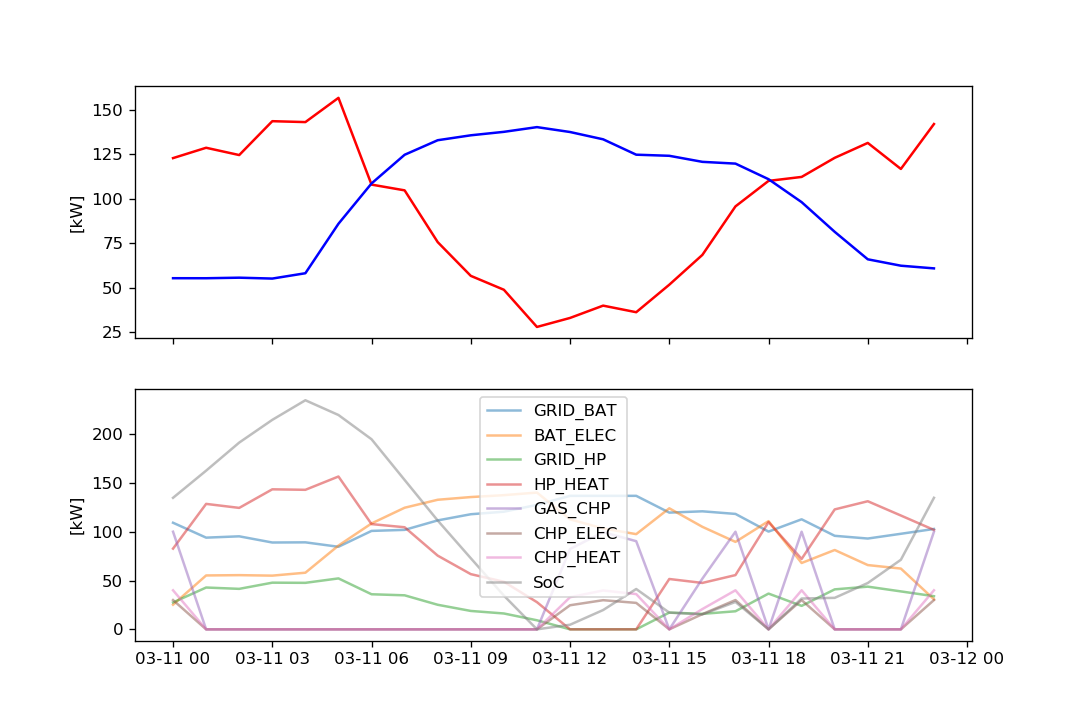

Text(0,0.5,'[kW]')

In [16]:
fig, ax = plt.subplots(2, figsize=(9, 6), sharex=True)

ax[0].plot(index, load_heat, "r-")
ax[0].plot(index, load_elec, "b-")

for c in results.columns:
    ax[1].plot(results[c], alpha=0.5, label=c)

ax[1].legend()

ax[0].set_ylabel("[kW]")
ax[1].set_ylabel("[kW]")

<IPython.core.display.Javascript object>


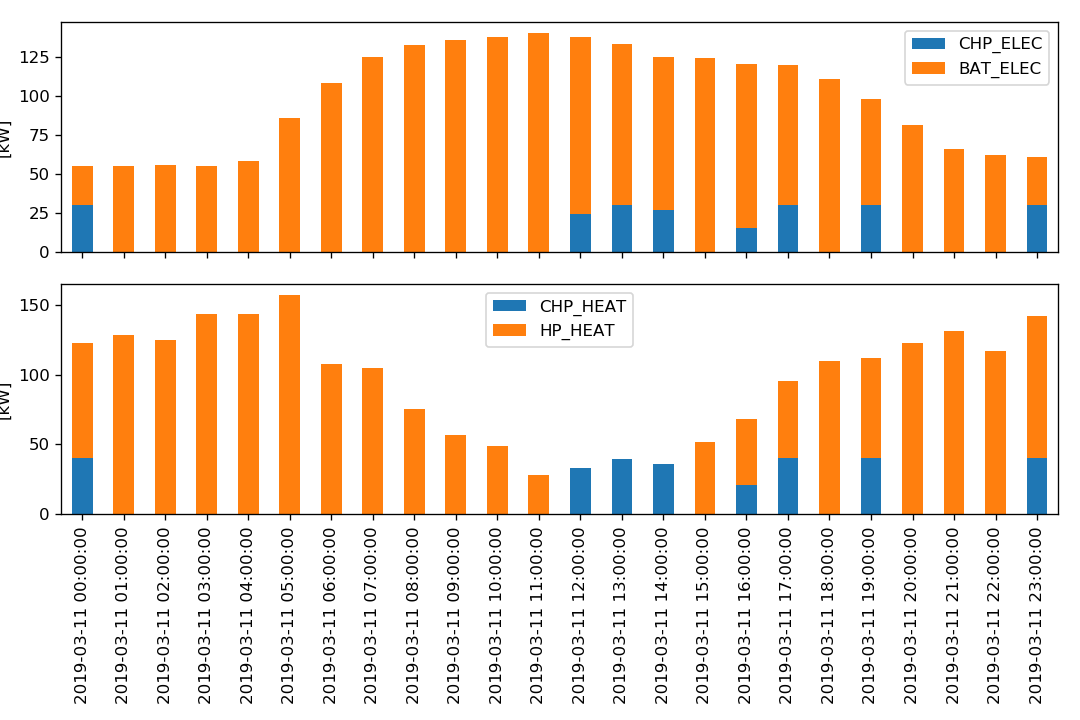

Text(70.7222,0.5,'[kW]')

In [17]:
fig, ax = plt.subplots(2, figsize=(9, 6), sharex=True)

results.loc[:, ["CHP_ELEC", "BAT_ELEC"]].plot(kind='bar', stacked=True, ax=ax[0])
results.loc[:, ["CHP_HEAT", "HP_HEAT"]].plot(kind='bar', stacked=True, ax=ax[1])

plt.tight_layout()
ax[0].set_ylabel("[kW]")
ax[1].set_ylabel("[kW]")

<IPython.core.display.Javascript object>


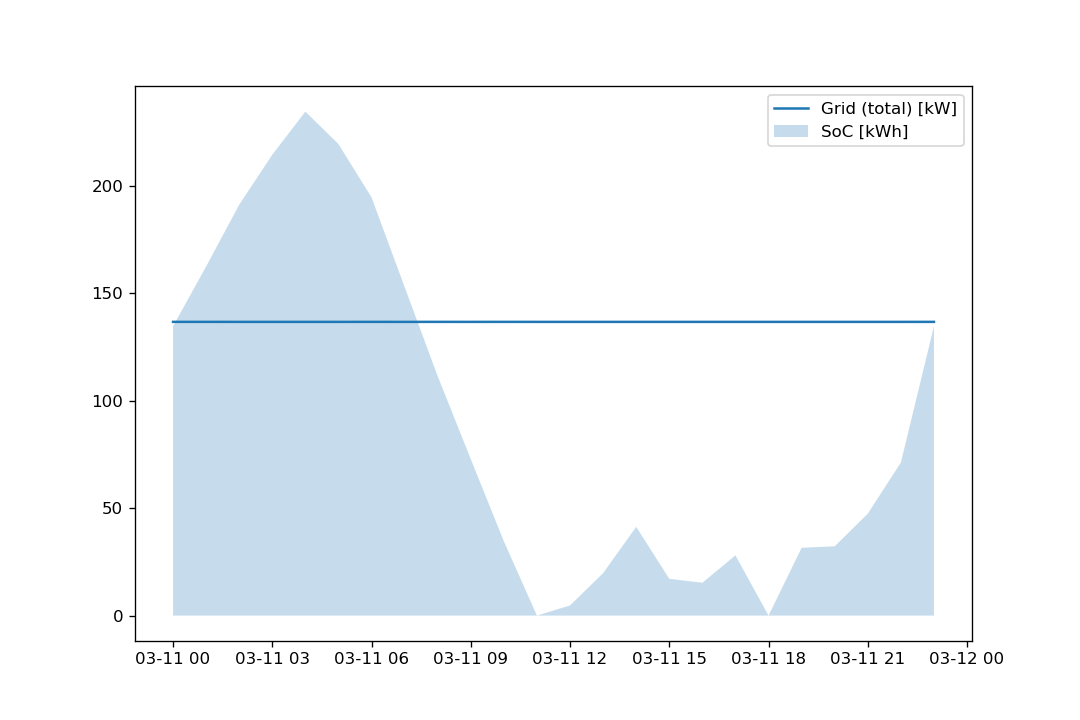

In [18]:
fig, ax = plt.subplots(figsize=(9, 6))

grid = results["GRID_HP"] + results["GRID_BAT"]

ax.plot(grid, label="Grid (total) [kW]")
ax.fill_between(x=results.index, y1=results.SoC, label="SoC [kWh]", alpha=0.25)

ax.legend()